### EMNIST Image Classification with Keras API on Cloud ML Engine

In [1]:
import os
PROJECT = "cloudml-demo-255023" # REPLACE WITH YOUR PROJECT ID
BUCKET = "emnist_cloudml-demo-255023" # REPLACE WITH YOUR BUCKET NAME
REGION = "us-central1" # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE = "keras_cnn"  # "linear", "dnn", "dnn_dropout", or "cnn"

# Do not change these
os.environ["PROJECT"] = PROJECT
os.environ["BUCKET"] = BUCKET
os.environ["REGION"] = REGION
os.environ["MODEL_TYPE"] = MODEL_TYPE
os.environ["TFVERSION"] = "1.14"

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
from tensorflow import keras
# from tensorflow.keras.utils import to_categorical
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.losses import categorical_crossentropy
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [4]:
!keras -v

/bin/sh: 1: keras: not found


In [5]:
train_data_path = 'gs://' + BUCKET + "/emnist/{}".format('emnist-balanced-train.csv')
test_data_path = 'gs://' + BUCKET+"/emnist/{}".format('emnist-balanced-test.csv')

In [6]:
train_data = pd.read_csv(train_data_path, header=None)

In [7]:
train_data.head(10)

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   45    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1   36    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   43    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
5   42    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
6   26    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
7   32    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
8   20    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
9    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  
5    0    0    0    0    0    0  
6    0    0    0    0    0    0  
7    0    0    0    0    0    0  
8    0    0    0    0    0    0  
9    0    0    0    0    0    0  

[10 rows x 785 columns]

In [8]:
# The classes of this balanced dataset are as follows. Index into it based on class label
class_mapping = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabdefghnqrt'
# source data: https://arxiv.org/pdf/1702.05373.pdf

In [9]:
class_mapping[42]

'h'

In [10]:
train_data.shape

(112800, 785)

### Data is flipped

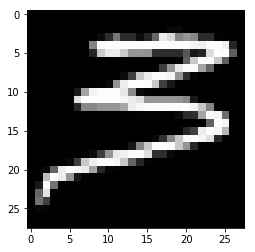

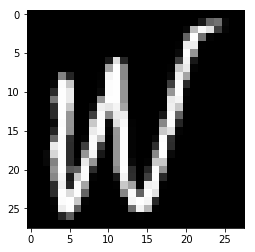

In [11]:
num_classes = len(train_data[0].unique())
row_num = 7

plt.imshow(train_data.values[row_num, 1:].reshape([28, 28]), cmap='Greys_r')
plt.show()

img_flip = np.transpose(train_data.values[row_num,1:].reshape(28, 28), axes=[1,0]) # img_size * img_size arrays
plt.imshow(img_flip, cmap='Greys_r')

plt.show()

In [12]:
def show_img(data, row_num):
    img_flip = np.transpose(data.values[row_num,1:].reshape(28, 28), axes=[1,0]) # img_size * img_size arrays
    plt.title('Class: ' + str(data.values[row_num,0]) + ', Label: ' + str(class_mapping[data.values[row_num,0]]))
    plt.imshow(img_flip, cmap='Greys_r')

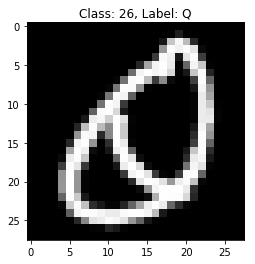

In [13]:
show_img(train_data, 139)

In [14]:
# 10 digits, 26 letters, and 11 capital letters that are different looking from their lowercase counterparts
num_classes = 47 
img_size = 28

def img_label_load(data_path, num_classes=None):
    data = pd.read_csv(data_path, header=None)
    data_rows = len(data)
    if not num_classes:
        num_classes = len(data[0].unique())
    
    # this assumes square imgs. Should be 28x28
    img_size = int(np.sqrt(len(data.iloc[0][1:])))
    
    # Images need to be transposed. This line also does the reshaping needed.
    imgs = np.transpose(data.values[:,1:].reshape(data_rows, img_size, img_size, 1), axes=[0,2,1,3]) # img_size * img_size arrays
    
    labels = keras.utils.to_categorical(data.values[:,0], num_classes) # one-hot encoding vectors
    
    return imgs/255., labels

### model, compile

In [15]:
model = keras.models.Sequential()

# model.add(keras.layers.Reshape((img_size,img_size,1), input_shape=(784,)))
model.add(keras.layers.Conv2D(filters=12, kernel_size=(5,5), strides=2, activation='relu', 
                              input_shape=(img_size,img_size,1)))
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=18, kernel_size=(3,3) , strides=2, activation='relu'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu'))
# model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

# model.add(keras.layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(units=150, activation='relu'))
model.add(keras.layers.Dense(units=num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 12, 12, 12)        312       
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 12)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 18)          1962      
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 18)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 24)          1752      
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
____

In [16]:
for layer in model.layers:
    print(layer.get_output_at(0).get_shape().as_list())

[None, 12, 12, 12]
[None, 12, 12, 12]
[None, 5, 5, 18]
[None, 5, 5, 18]
[None, 4, 4, 24]
[None, 384]
[None, 150]
[None, 47]


### Train

In [17]:
X, y = img_label_load(train_data_path)
print(X.shape)

(112800, 28, 28, 1)


In [18]:
data_generator = keras.preprocessing.image.ImageDataGenerator(validation_split=.2)
## consider using this for more variety
data_generator_with_aug = keras.preprocessing.image.ImageDataGenerator(validation_split=.2,
                                            width_shift_range=.2, height_shift_range=.2,
                                            rotation_range=60, zoom_range=.2, shear_range=.3)

# if already ran this above, no need to do it again
# X, y = img_label_load(train_data_path)
# print("X.shape: ", X.shape)

training_data_generator = data_generator.flow(X, y, subset='training')
validation_data_generator = data_generator.flow(X, y, subset='validation')
history = model.fit_generator(training_data_generator, 
                              steps_per_epoch=500, epochs=5, # can change epochs to 10
                              validation_data=validation_data_generator)

Epoch 1/5
500/500 [==============================] - 23s 47ms/step - loss: 2.4451 - acc: 0.3446 - val_loss: 1.3931 - val_acc: 0.5935
Epoch 2/5
500/500 [==============================] - 29s 59ms/step - loss: 1.4248 - acc: 0.5770 - val_loss: 0.9997 - val_acc: 0.6960
Epoch 3/5
500/500 [==============================] - 27s 53ms/step - loss: 1.1210 - acc: 0.6562 - val_loss: 0.8300 - val_acc: 0.7444
Epoch 4/5
500/500 [==============================] - 31s 63ms/step - loss: 0.9881 - acc: 0.6909 - val_loss: 0.7728 - val_acc: 0.7552
Epoch 5/5
500/500 [==============================] - 27s 55ms/step - loss: 0.9227 - acc: 0.7074 - val_loss: 0.7098 - val_acc: 0.7688


In [19]:
test_X, test_y = img_label_load(test_data_path)
test_data_generator = data_generator.flow(X, y)

model.evaluate_generator(test_data_generator)

[0.684920728379953, 0.7751507]

### Look at some predictions

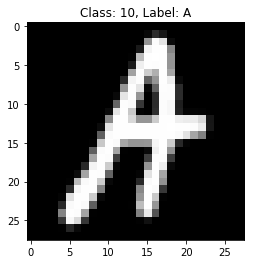

In [20]:
test_data = pd.read_csv(test_data_path, header=None)
show_img(test_data, 124)

In [21]:
X_test, y_test = img_label_load(test_data_path) # loads images and orients for model

In [22]:
def run_prediction(idx):
    result = np.argmax(model.predict(X_test[idx:idx+1]))
    print('Prediction: ', result, ', Char: ', class_mapping[result])
    print('Label: ', test_data.values[idx,0])
    show_img(test_data, idx)

Prediction:  21 , Char:  L
Label:  21
Prediction:  16 , Char:  G
Label:  16
Prediction:  44 , Char:  q
Label:  44
Prediction:  4 , Char:  4
Label:  4
Prediction:  41 , Char:  g
Label:  41
Prediction:  7 , Char:  7
Label:  7
Prediction:  41 , Char:  g
Label:  41
Prediction:  43 , Char:  n
Label:  43
Prediction:  12 , Char:  C
Label:  12


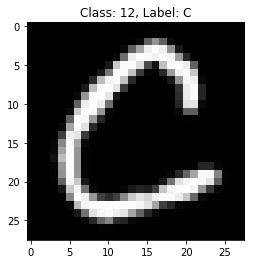

In [23]:
import random

for _ in range(1,10):
    idx = random.randint(0, 47-1)
    run_prediction(idx)

34

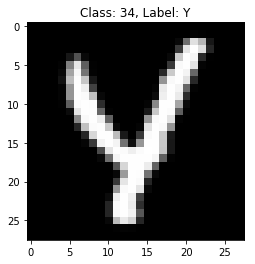

In [24]:
show_img(test_data, 121)
np.argmax(y_test[121])

### Export model to TF SavedModel for CMLE Prediction
https://www.tensorflow.org/api_docs/python/tf/keras/estimator/model_to_estimator

In [31]:
# First, convert Keras Model to TensorFlow Estimator
model_input_name = model.input_names[0]
estimator_model = keras.estimator.model_to_estimator(keras_model=model, 
                                                     model_dir='gs://' + BUCKET + "/emnist/{}".format('estimator_model'))
print(model_input_name)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_model_dir': 'gs://emnist_cloudml-demo-255023/emnist/estimator_model', '_global_id_in_cluster': 0, '_save_summary_steps': 100, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f107a422358>, '_master': '', '_protocol': None, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_checkpoints_secs': 600, '_train_distribute': None, '_task_type': 'worker', '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_device_fn': None, '_experimental_distribute': None, '_save_checkpoints_steps': None, '_experimental_max_worker_delay_secs': None, '_is_chief': True, '_service': None, '_evaluation_master': '', '_eval_distribute': None, '_num_ps_replicas': 0, '_log_step_count_steps': 100, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_tf_random_seed': None}
conv2d_inp

In [32]:
# Next, export the TensorFlow Estimator to SavedModel
from functools import partial
import tensorflow as tf

def serving_input_receiver_fn():
    input_ph = tf.placeholder(tf.string, shape=[None], name='image_binary')
    images = tf.map_fn(partial(tf.image.decode_image, channels=1), input_ph, dtype=tf.uint8)
    images = tf.cast(images, tf.float32) / 255.
    images.set_shape([None, 28, 28, 1])
    
    # the first key is the name of first layer of the (keras) model. 
    # The second key is the name of the key that will be passed in the prediction request
    return tf.estimator.export.ServingInputReceiver({model_input_name: images}, {'bytes': input_ph})

In [33]:
export_path = estimator_model.export_savedmodel('gs://' + BUCKET + "/emnist/{}".format('export'), serving_input_receiver_fn=serving_input_receiver_fn)
export_path

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Restoring parameters from gs://emnist_cloudml-demo-255023/emnist/estimator_model/keras/keras_model.ckpt
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: gs://emnist_cloudml-demo-255023/emnist/export/temp-b'1570496918'/saved_model.pb


b'gs://emnist_cloudml-demo-255023/emnist/export/1570496918'

### Keras exports

In [38]:
with open('model.json', 'w') as f:
    f.write(model.to_json())

model.save_weights('./model.h5')

model.save('./full_model.h5')
!ls -lh

total 1.3M
drwxr-xr-x 3 jupyter jupyter 4.0K Oct  8 00:19 emnist
-rw-r--r-- 1 jupyter jupyter  84K Oct  8 01:09 emnist_model.ipynb
-rw-r--r-- 1 jupyter jupyter 854K Oct  8 01:11 full_model.h5
-rw-r--r-- 1 jupyter jupyter 293K Oct  8 01:11 model.h5
-rw-r--r-- 1 jupyter jupyter 3.2K Oct  8 01:11 model.json


In [40]:
!gsutil cp ./full_model.h5 gs://emnist_cloudml-demo-255023/emnist
!gsutil cp ./model.h5 gs://emnist_cloudml-demo-255023/emnist  

Copying file://./full_model.h5 [Content-Type=application/octet-stream]...
/ [1 files][853.9 KiB/853.9 KiB]                                                
Operation completed over 1 objects/853.9 KiB.                                    
Copying file://./model.h5 [Content-Type=application/octet-stream]...
/ [1 files][292.3 KiB/292.3 KiB]                                                
Operation completed over 1 objects/292.3 KiB.                                    


### Plot loss and accuracy

dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


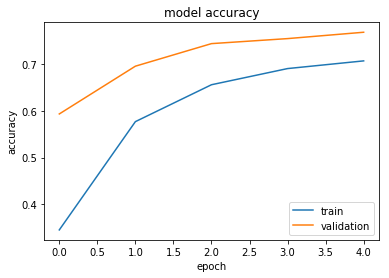

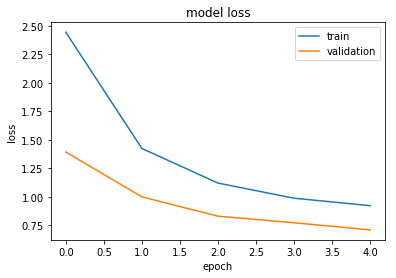

In [41]:
import matplotlib.pyplot as plt

print(history.history.keys())

# accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

# loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Create some output files for sending to Cloud ML Engine's online prediction

In [42]:
from PIL import Image

def export_png(row_num, data=test_data):
    array = np.transpose(data.values[row_num,1:].reshape(28, 28), axes=[1,0])
    img = Image.fromarray(array.astype(np.uint8))
    filename = 'class_' + str(data.values[row_num,0]) + '_label_' + str(class_mapping[data.values[row_num,0]]) + '.png'
    img.save(filename)

In [78]:
export_png(138)

In [79]:
import base64
import json

img_filename = 'class_15_label_F.png'
json_filename = 'class_15_label_F.json'

with open(img_filename, 'rb') as img_file :
    img_str = base64.b64encode(img_file.read())
    print(str(img_str))

    json_img = {"image_bytes":{"b64": str(img_str) }}
    print(type(json_img['image_bytes']['b64']))

with open(json_filename, 'w') as outfile:
    json.dump(json_img, outfile)

b'iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAAAAABXZoBIAAABCElEQVR4nGNgIA0ww1lM6FKMigmKjDi0sagsfjtPBKsUo2Lxhk8/L6vAVKLIKTX4v5j96e07bBoVF3+5Hc3NwoJNjqX4891oTiQBZNcKmDMsXv8dhyQDw4vN3xhwSH689vMTAy7J///RHIERQiguhFCMfD9/MLDzMbGwsIqz/n7xAyoKoRSW8Oz5auDK/PQ3qzjrzxMpD5F1MjDKZjKysvyXef/hyb8H176i6GS3klXgD5J7uPb41X8MX75/RHUaIzOL0KxPDTy4HKhw+rYRTq8IC1x8jEuSw0fs6gdckhK+HP/+45IUEvrzmQGHJIuD+PMDf3Dp/P/10CMGXEAhGWeSZEBOzEQBAPgqTz5JsoY7AAAAAElFTkSuQmCC'
<class 'str'>


In [80]:
MODEL_NAME='emnist_kaggle_keras'
INPUT_DATA_FILE='./test_f.json'
VERSION_NAME='v1'

In [81]:
!gcloud ai-platform predict --model=$MODEL_NAME --version=$VERSION_NAME --json-instances=$INPUT_DATA_FILE

DENSE_1
[6.634134592786722e-07, 2.042359483311884e-05, 2.6191171855316497e-05, 4.277302650734782e-05, 0.0014462713152170181, 9.220471110893413e-05, 0.00041059718932956457, 2.1374818970798515e-05, 1.570067433931399e-05, 2.573578603914939e-05, 0.00027754215989261866, 4.998327494831756e-05, 6.301754910964519e-05, 2.681431169548887e-06, 0.002228258177638054, 0.12143951654434204, 0.0014957406092435122, 0.00016942521324381232, 0.00018041602743323892, 0.00017201516311615705, 4.793802145286463e-05, 9.359922114526853e-05, 1.640193119101241e-07, 1.3454309737426229e-06, 4.362253093859181e-06, 0.00017580427811481059, 0.0002203742478741333, 1.5992914995877072e-05, 6.161366036394611e-05, 4.4365892790665384e-06, 1.634199861655361e-06, 1.1739042520275689e-06, 1.0047617251984775e-05, 2.3701829832134536e-06, 1.562327452120371e-05, 3.2363412174163386e-05, 2.8912736524944194e-05, 4.744784746435471e-05, 4.689976049121469e-05, 0.00024737464264035225, 0.781351625919342, 0.0007158305961638689, 8.5838903032708

In [ ]:
{"bytes": {"b64": "iVBORw0KGgoAAAANSUhEUgAAABwAAAAcCAAAAABXZoBIAAABCElEQVR4nGNgIA0ww1lM6FKMigmKjDi0sagsfjtPBKsUo2Lxhk8/L6vAVKLIKTX4v5j96e07bBoVF3+5Hc3NwoJNjqX4891oTiQBZNcKmDMsXv8dhyQDw4vN3xhwSH689vMTAy7J///RHIERQiguhFCMfD9/MLDzMbGwsIqz/n7xAyoKoRSW8Oz5auDK/PQ3qzjrzxMpD5F1MjDKZjKysvyXef/hyb8H176i6GS3klXgD5J7uPb41X8MX75/RHUaIzOL0KxPDTy4HKhw+rYRTq8IC1x8jEuSw0fs6gdckhK+HP/+45IUEvrzmQGHJIuD+PMDf3Dp/P/10CMGXEAhGWeSZEBOzEQBAPgqTz5JsoY7AAAAAElFTkSuQmCC"}}

In [82]:
np.argmax([6.634134592786722e-07, 2.042359483311884e-05, 2.6191171855316497e-05, 4.277302650734782e-05, 0.0014462713152170181, 9.220471110893413e-05, 0.00041059718932956457, 2.1374818970798515e-05, 1.570067433931399e-05, 2.573578603914939e-05, 0.00027754215989261866, 4.998327494831756e-05, 6.301754910964519e-05, 2.681431169548887e-06, 0.002228258177638054, 0.12143951654434204, 0.0014957406092435122, 0.00016942521324381232, 0.00018041602743323892, 0.00017201516311615705, 4.793802145286463e-05, 9.359922114526853e-05, 1.640193119101241e-07, 1.3454309737426229e-06, 4.362253093859181e-06, 0.00017580427811481059, 0.0002203742478741333, 1.5992914995877072e-05, 6.161366036394611e-05, 4.4365892790665384e-06, 1.634199861655361e-06, 1.1739042520275689e-06, 1.0047617251984775e-05, 2.3701829832134536e-06, 1.562327452120371e-05, 3.2363412174163386e-05, 2.8912736524944194e-05, 4.744784746435471e-05, 4.689976049121469e-05, 0.00024737464264035225, 0.781351625919342, 0.0007158305961638689, 8.583890303270891e-05, 2.8820650754823873e-07, 0.0005149501957930624, 2.8878771445306484e-06, 0.08808852732181549])

40